In [56]:
import pandas as pd
import seaborn as sns
import numpy as np

In [57]:
#Read in data from two tabs in bank churn sheet
customer = pd.read_excel("C:/Users/dlrum/Documents/Maven/learning-data-science/Python/bank-churn-analysis_data-prep-&-eda/data/Bank_Churn_Messy.xlsx",sheet_name = 0)
account = pd.read_excel("C:/Users/dlrum/Documents/Maven/learning-data-science/Python/bank-churn-analysis_data-prep-&-eda/data/Bank_Churn_Messy.xlsx",sheet_name = 1)

In [58]:
#Merge two tabs from bank churn sheet
customer = customer.drop(columns = 'Tenure')
df = account.merge(customer, how = 'left', on = 'CustomerId')

In [59]:
##Data Cleaning
#check for duplicate entries
df[df.duplicated()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 1 to 10003
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       4 non-null      int64  
 1   Balance          4 non-null      object 
 2   NumOfProducts    4 non-null      int64  
 3   HasCrCard        4 non-null      object 
 4   Tenure           4 non-null      int64  
 5   IsActiveMember   4 non-null      object 
 6   Exited           4 non-null      int64  
 7   Surname          4 non-null      object 
 8   CreditScore      4 non-null      int64  
 9   Geography        4 non-null      object 
 10  Gender           4 non-null      object 
 11  Age              4 non-null      float64
 12  EstimatedSalary  4 non-null      object 
dtypes: float64(1), int64(5), object(7)
memory usage: 448.0+ bytes


In [60]:
#remove duplicate entries
df = df.drop_duplicates()

In [61]:
#check datatypes
df.dtypes

CustomerId           int64
Balance             object
NumOfProducts        int64
HasCrCard           object
Tenure               int64
IsActiveMember      object
Exited               int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
EstimatedSalary     object
dtype: object

In [62]:
#remove currency symbol from "Balance" and convert to numeric
df['Balance'] = pd.to_numeric(df.Balance.str.replace('€',''))
#convert "HasCrCard" from Yes or No field to zero or one and convert to numeric
df['HasCrCard'] = pd.to_numeric(np.where(df.HasCrCard == 'Yes', 1, 0))
#convert "IsActiveMember" from Yes or no to zero or one and convert to numeric
df['IsActiveMember'] = pd.to_numeric(np.where(df.IsActiveMember == 'Yes', 1, 0))
#remove currency symbol from "EstimatedSalary" and convert to numeric
df['EstimatedSalary'] = pd.to_numeric(df.EstimatedSalary.str.replace('€',''))

In [63]:
#check for missing values
df[df.isna().any(axis=1)]

,CustomerId,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Surname,CreditScore,Geography,Gender,Age,EstimatedSalary
29,15728693,141349.43,1,1,3,1,0,NaN,574,Germany,Female,NaN,-999999.0
122,15580203,120193.42,1,0,6,0,0,NaN,674,Spain,Male,NaN,-999999.0
9390,15756954,0.00,1,1,2,1,0,NaN,538,France,Female,NaN,-999999.0


In [64]:
#replace categorical NaN values with "MISSING"
df[['Surname','Geography','Gender','HasCrCard']] = df[['Surname','Geography','Gender','HasCrCard']].fillna('MISSING')
#replace Numerical NaN values with the median
df[['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']] = df[['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']].fillna(df[['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']].median())

In [65]:
#explore numeric columns for outliers or abnormalities
df[['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']].describe()

,Balance,NumOfProducts,CreditScore,Age,Tenure,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,76485.889288,1.530200,650.528800,38.921500,5.012800,99762.195289
std,62397.405202,0.581654,96.653299,10.487552,2.892174,60583.863580
min,0.000000,1.000000,350.000000,18.000000,0.000000,-999999.000000
25%,0.000000,1.000000,584.000000,32.000000,3.000000,50910.677500
50%,97198.540000,1.000000,652.000000,37.000000,5.000000,100191.725000
75%,127644.240000,2.000000,718.000000,44.000000,7.000000,149388.247500
max,250898.090000,4.000000,850.000000,92.000000,10.000000,199992.480000


In [66]:
#Explore Abnormal minimum salary

#replace rows with negative salary with column median
df['EstimatedSalary'] = np.where(df['EstimatedSalary'] < 0, df['EstimatedSalary'].median(), df['EstimatedSalary'])
#Value Surname Missing, estimated salary incorrect.
df[df['EstimatedSalary'] < 0]

,CustomerId,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Surname,CreditScore,Geography,Gender,Age,EstimatedSalary


In [67]:
#Find any country names that are identical but different spelling and replace
df['Geography'].value_counts()
df['Geography'] = np.where((df.Geography == 'FRA') | (df.Geography == 'French'), 'France', df.Geography)

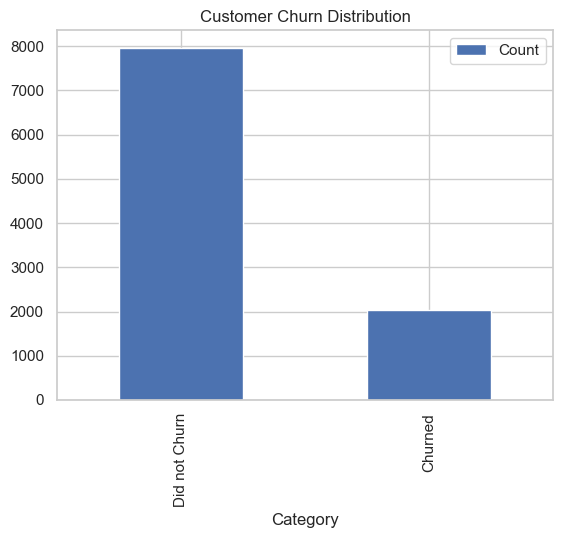

In [68]:
##EDA
#build a bar chart showing count of churners vs non churners

vc = df['Exited'].value_counts() 
data = pd.DataFrame({
    'Category': ['Did not Churn', 'Churned'],
    'Count': [vc.get(0, 0), vc.get(1, 0)]
})

data.plot.bar(x='Category', y='Count', title='Customer Churn Distribution');


In [69]:
#Explore the categorical variables vs. the target, and look at the percentage of Churners by “Geography” and “Gender”
#Categorical Variables = 'Geography','Gender','HasCrCard'

geo_churn = df.groupby('Geography')['Exited'].mean() * 100
gender_churn = df.groupby('Gender')['Exited'].mean() * 100
CrCardChurn = df.groupby('HasCrCard')['Exited'].mean() * 100

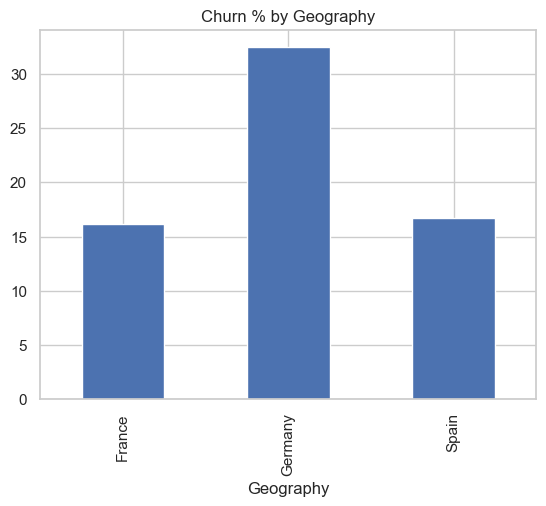

In [70]:
#plot by category
geo_churn.plot(kind='bar', title='Churn % by Geography');

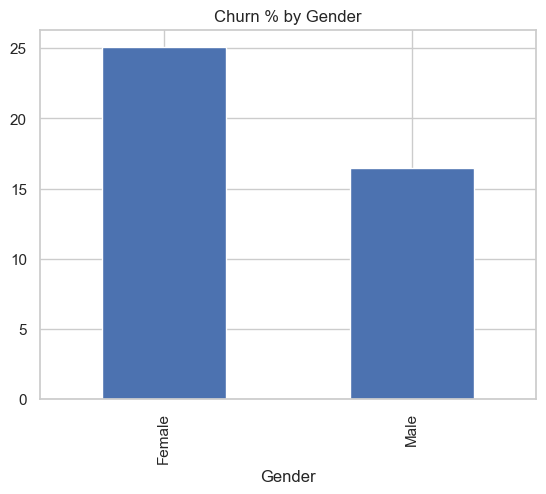

In [71]:
gender_churn.plot(kind='bar', title='Churn % by Gender');

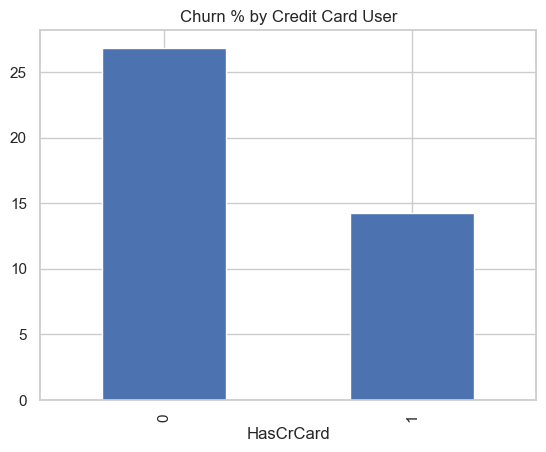

In [72]:
CrCardChurn.plot(kind = 'bar', title = 'Churn % by Credit Card User');

In [73]:
#Build box plots for each numeric field, broken out by churners vs. non-churners
#Numeric Variables = 'Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary'

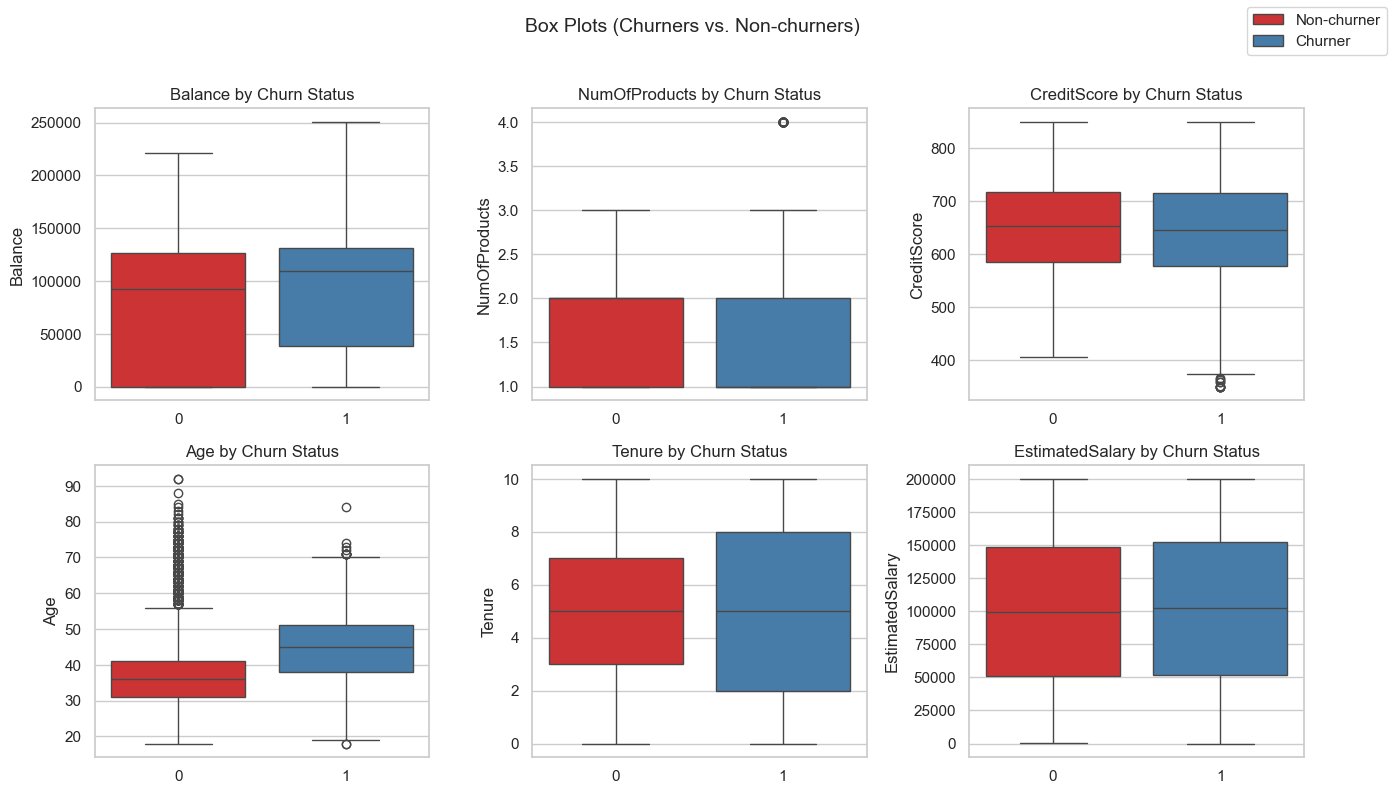

In [74]:

import matplotlib.pyplot as plt

numeric_cols = ['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']

sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(
        data=df,
        x='Exited', y=col,
        hue='Exited',             # color by churn status
        palette='Set1',
        ax=ax,
        dodge=False               # single box per class
    )
    ax.set_title(f'{col} by Churn Status')
    ax.set_xlabel('')
    ax.set_ylabel(col)
    ax.legend_.remove()          # remove redundant legend per subplot

# One legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Non-churner', 'Churner'], loc='upper right')

fig.suptitle('Box Plots (Churners vs. Non-churners)', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.95, 0.96])
plt.show()


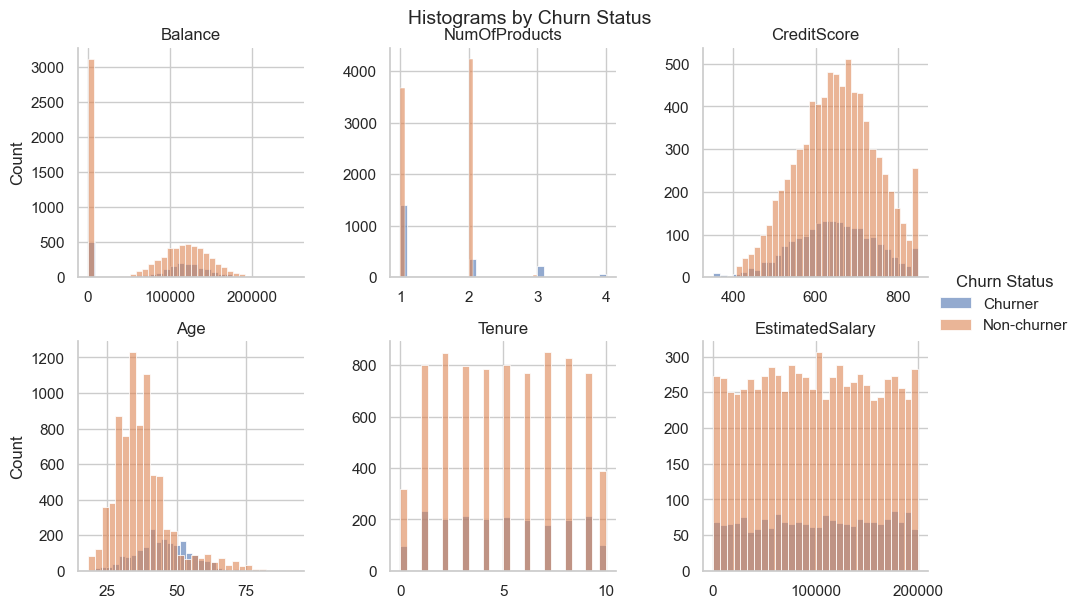

In [75]:


numeric_cols = ['Balance','NumOfProducts','CreditScore','Age','Tenure','EstimatedSalary']
df['Exited'] = df['Exited'].astype(int).map({0: 'Non-churner', 1: 'Churner'})
long_df = df.melt(id_vars='Exited', value_vars=numeric_cols,
                  var_name='Variable', value_name='Value')
sns.set(style='whitegrid')
g = sns.FacetGrid(
    long_df, col='Variable', hue='Exited', col_wrap=3, sharex=False, sharey=False, height=3.2
)

# Histogram with KDE optional
g.map(sns.histplot, 'Value', stat='count', bins=30, alpha=0.6)
g.add_legend(title='Churn Status')

g.set_titles('{col_name}')
g.set_axis_labels('', 'Count')
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Histograms by Churn Status', fontsize=14)

plt.show()


In [76]:
#Prepare a dataset that is suitable for modeling by dropping unnecessary variables

modelling_df = df.drop(columns = ['CustomerId', 'Surname',])

In [77]:
#create dummies
modelling_df = pd.get_dummies(modelling_df, drop_first = True)

In [78]:
#add a useful ratio
modelling_df['Balance_v_sal'] = modelling_df['Balance'] / modelling_df['EstimatedSalary']
modelling_df.head()

,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,CreditScore,Age,EstimatedSalary,Exited_Non-churner,Geography_Germany,Geography_Spain,Gender_Male,Balance_v_sal
0,0.00,1,1,2,1,619,42.0,101348.88,False,False,False,False,0.000000
2,83807.86,1,1,1,1,608,41.0,112542.58,True,False,True,False,0.744677
3,159660.80,3,0,8,0,502,42.0,113931.57,False,False,False,False,1.401375
4,0.00,2,0,1,0,699,39.0,93826.63,True,False,False,False,0.000000
5,125510.82,1,1,2,1,850,43.0,79084.10,True,False,True,False,1.587055


<Axes: ylabel='Balance_v_sal'>

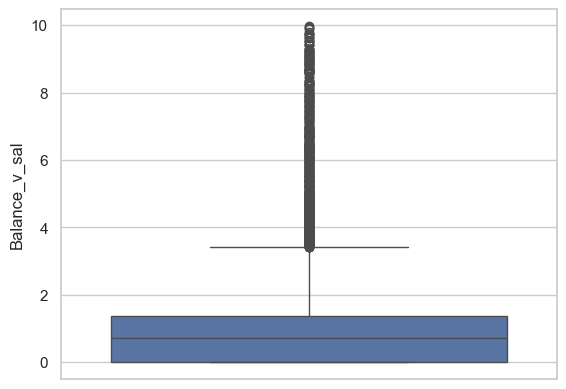

In [79]:
#plot the ratio and check trends
sns.boxplot(data = modelling_df.query('Balance_v_sal < 10'), y = 'Balance_v_sal')

In [80]:
modelling_df.describe()

,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,CreditScore,Age,EstimatedSalary,Balance_v_sal
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,76485.889288,1.530200,0.515100,5.012800,0.515100,650.528800,38.921500,100092.252507,3.878703
std,62397.405202,0.581654,0.499797,2.892174,0.499797,96.653299,10.487552,57510.146401,108.337260
min,0.000000,1.000000,0.000000,0.000000,0.000000,350.000000,18.000000,11.580000,0.000000
25%,0.000000,1.000000,0.000000,3.000000,0.000000,584.000000,32.000000,51002.110000,0.000000
50%,97198.540000,1.000000,1.000000,5.000000,1.000000,652.000000,37.000000,100196.062500,0.747002
75%,127644.240000,2.000000,1.000000,7.000000,1.000000,718.000000,44.000000,149388.247500,1.514022
max,250898.090000,4.000000,1.000000,10.000000,1.000000,850.000000,92.000000,199992.480000,10614.655440


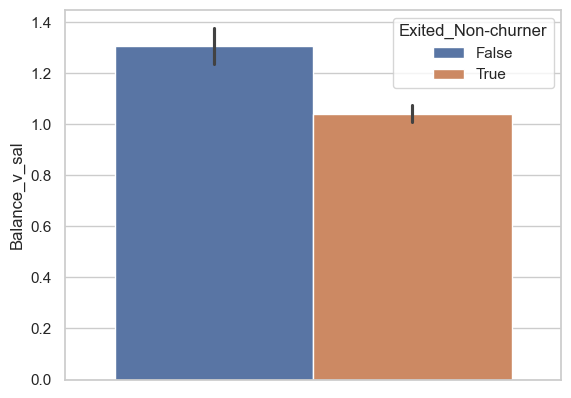

In [81]:
sns.barplot(data = modelling_df.query('Balance_v_sal < 10'), y = 'Balance_v_sal', hue = 'Exited_Non-churner');